<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert-second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install transformers --quiet
!pip install wget --quiet

In [34]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [38]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [39]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42) # .15 .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941 .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11529,)
(8646,)
(2883,)
(2883,)


Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**********
Model: cointegrated/rubert-tiny2
Epoch 1/5


100%|██████████| 4323/4323 [02:23<00:00, 30.04it/s]


Train loss 0.4498737098118583 accuracy 0.8723108952116586
Valid:
Accuracy: 90.25 %
Recall: 89.74 %
precision: 0.8869319736776633, recall: 0.9012860828898566, f1score: 0.8932051198392784
Test:
Accuracy: 92.16 %
Recall: 91.48 %
precision: 0.9060639295535104, recall: 0.9198500506185987, f1score: 0.9123067555607238
*********************
              precision    recall  f1-score   support

           0     0.9574    0.9249    0.9409      1944
           1     0.8547    0.9148    0.8837       939

    accuracy                         0.9216      2883
   macro avg     0.9061    0.9199    0.9123      2883
weighted avg     0.9240    0.9216    0.9223      2883

Accuracy: 92.16 %
Recall: 91.48 %
Precision: 85.47 %
F1-score: 88.37 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1798
False Positives:  146
False Negatives:  80
True Positives:  859
Epoch 2/5


100%|██████████| 4323/4323 [02:10<00:00, 33.03it/s]


Train loss 0.33719143378257216 accuracy 0.9240111034004164
Valid:
Accuracy: 91.16 %
Recall: 89.95 %
precision: 0.8975804266617011, recall: 0.9086010320915981, f1score: 0.9025989382619839
Test:
Accuracy: 92.44 %
Recall: 92.23 %
precision: 0.9087909596997135, recall: 0.9238346218067552, f1score: 0.9155386228027738
*********************
              precision    recall  f1-score   support

           0     0.9610    0.9254    0.9429      1944
           1     0.8566    0.9223    0.8882       939

    accuracy                         0.9244      2883
   macro avg     0.9088    0.9238    0.9155      2883
weighted avg     0.9270    0.9244    0.9251      2883

Accuracy: 92.44 %
Recall: 92.23 %
Precision: 85.66 %
F1-score: 88.82 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1799
False Positives:  145
False Negatives:  73
True Positives:  866
Epoch 3/5


100%|██████████| 4323/4323 [02:10<00:00, 33.03it/s]


Train loss 0.2523360289041234 accuracy 0.9473745084432107
Valid:
Accuracy: 91.16 %
Recall: 91.38 %
precision: 0.8964272750118671, recall: 0.9121117561683599, f1score: 0.9032164806273006
Test:
Accuracy: 92.4 %
Recall: 93.08 %
precision: 0.9075770606311683, recall: 0.9257796578971589, f1score: 0.9155080946702454
*********************
              precision    recall  f1-score   support

           0     0.9650    0.9208    0.9424      1944
           1     0.8502    0.9308    0.8887       939

    accuracy                         0.9240      2883
   macro avg     0.9076    0.9258    0.9155      2883
weighted avg     0.9276    0.9240    0.9249      2883

Accuracy: 92.4 %
Recall: 93.08 %
Precision: 85.02 %
F1-score: 88.87 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1790
False Positives:  154
False Negatives:  65
True Positives:  874
Epoch 4/5


100%|██████████| 4323/4323 [02:10<00:00, 33.03it/s]


Train loss 0.1959606958770245 accuracy 0.9603284755956512
Valid:
Accuracy: 91.22 %
Recall: 89.44 %
precision: 0.8989411874810063, recall: 0.9078713110788583, f1score: 0.9030917030892585
Test:
Accuracy: 92.47 %
Recall: 91.05 %
precision: 0.9105287193018063, recall: 0.9210637465651665, f1score: 0.9154322941033581
*********************
              precision    recall  f1-score   support

           0     0.9557    0.9316    0.9435      1944
           1     0.8654    0.9105    0.8874       939

    accuracy                         0.9247      2883
   macro avg     0.9105    0.9211    0.9154      2883
weighted avg     0.9263    0.9247    0.9252      2883

Accuracy: 92.47 %
Recall: 91.05 %
Precision: 86.54 %
F1-score: 88.74 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1811
False Positives:  133
False Negatives:  84
True Positives:  855
Epoch 5/5


100%|██████████| 4323/4323 [02:10<00:00, 33.04it/s]


Train loss 0.16947868340444788 accuracy 0.9661114966458478
Valid:
Accuracy: 90.98 %
Recall: 88.72 %
precision: 0.8966651195662493, recall: 0.9042815674891147, f1score: 0.9002454007324759
Test:
Accuracy: 92.37 %
Recall: 89.99 %
precision: 0.9105368446453426, recall: 0.9175393444562774, f1score: 0.9138814060089939
*********************
              precision    recall  f1-score   support

           0     0.9508    0.9352    0.9429      1944
           1     0.8702    0.8999    0.8848       939

    accuracy                         0.9237      2883
   macro avg     0.9105    0.9175    0.9139      2883
weighted avg     0.9246    0.9237    0.9240      2883

Accuracy: 92.37 %
Recall: 89.99 %
Precision: 87.02 %
F1-score: 88.48 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1818
False Positives:  126
False Negatives:  94
True Positives:  845
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

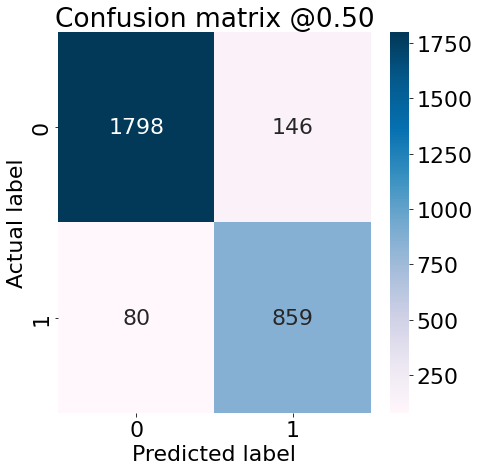

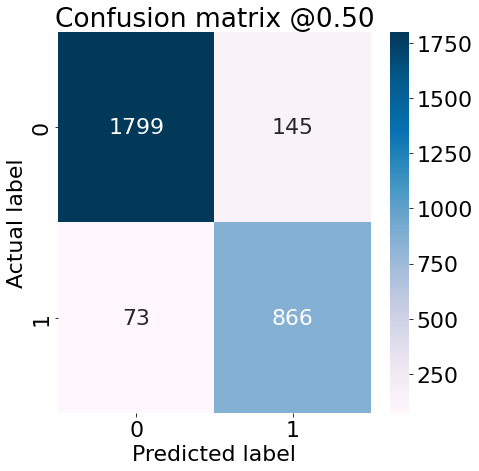

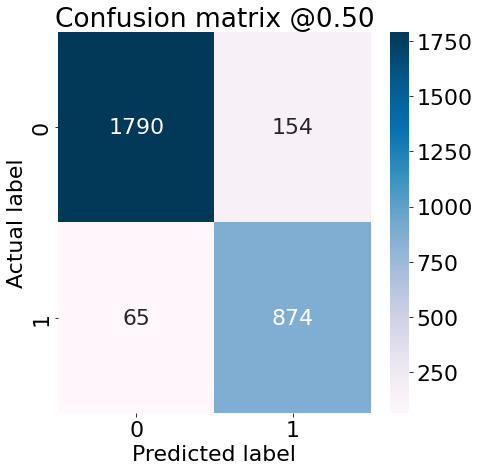

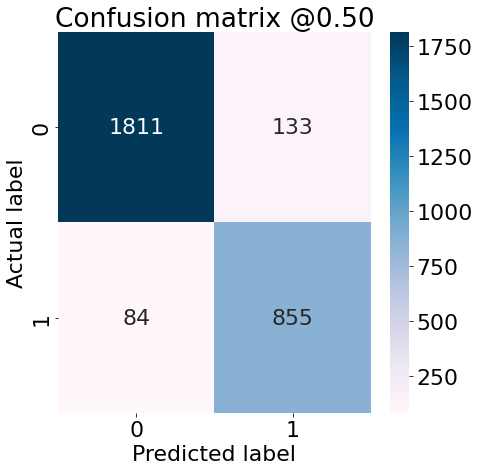

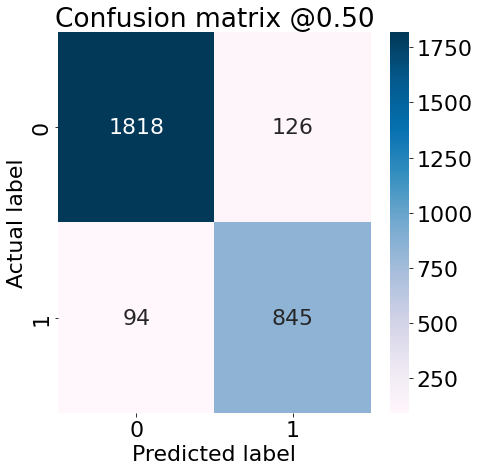

In [40]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny2',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=5
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)